# 자세 인식 모델

## 1. 버전

In [1]:
import tensorflow as tf
tf.__version__

'2.11.0'

## 2. 데이터셋 준비 및 데이터 전처리(데이터 어그멘테이션)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 처음 한 번 실행, train, test 데이터셋 분리
#splitfolders.ratio('/content/gdrive/MyDrive/pose','/content/gdrive/MyDrive/pose/dataset',seed=77, ratio=(0.8,0.2))

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = '/content/gdrive/MyDrive/pose/dataset'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=10,
                                                  class_mode='categorical',
                                                  target_size=(150, 150))

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                      batch_size=10,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

Found 116 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## 3. 모델학습

In [6]:
vgg_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                        include_top = False,
                                        input_shape=(160, 160, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [7]:
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

vgg_model.trainable = False

#추가 코드
# 확인 - before
for layer in vgg_model.layers:
    print(layer, layer.trainable)
##

x = vgg_model.layers[-1].output
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Flatten()(x)


preds = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=preds)
model.summary()

#추가코드
for layer in model.layers[-7::]:
        layer.trainable = True
## 

#adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#추가 코드
# 확인 - after
for layer in model.layers:
    print(layer, layer.trainable)
##

<keras.engine.input_layer.InputLayer object at 0x7fa4a275b130> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa520591640> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa495d70f10> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fa495d05ac0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa4988c0130> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa4988c0a30> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fa495d09640> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa4988d30a0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa4988d3b20> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa4988ce670> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fa4988d8d60> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa4988e42b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa4988e49d0> False
<keras.layers.convolut

In [8]:
history=model.fit(
        train_generator,
        steps_per_epoch=11,
        epochs=20,
        validation_data=test_generator,
        validation_steps=3)

Epoch 1/20
11/11 [==============================] - 19s 1s/step - loss: 1.4169 - accuracy: 0.6604 - val_loss: 0.6344 - val_accuracy: 0.6000
Epoch 2/20
11/11 [==============================] - 7s 549ms/step - loss: 0.4325 - accuracy: 0.8396 - val_loss: 0.1324 - val_accuracy: 0.9667
Epoch 3/20
11/11 [==============================] - 5s 457ms/step - loss: 0.2065 - accuracy: 0.9340 - val_loss: 0.2544 - val_accuracy: 0.9000
Epoch 4/20
11/11 [==============================] - 6s 592ms/step - loss: 0.2014 - accuracy: 0.9434 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 5/20
11/11 [==============================] - 5s 471ms/step - loss: 0.2669 - accuracy: 0.9057 - val_loss: 0.0847 - val_accuracy: 0.9667
Epoch 6/20
11/11 [==============================] - 5s 454ms/step - loss: 0.1694 - accuracy: 0.9623 - val_loss: 0.1540 - val_accuracy: 0.9667
Epoch 7/20
11/11 [==============================] - 6s 595ms/step - loss: 0.2017 - accuracy: 0.9057 - val_loss: 0.0479 - val_accuracy: 0.9667
Epoch 8/

## 4. 평가

In [9]:
import numpy as np

# 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Evaluate --


<ipython-input-9-5fa8b0dc6404>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, steps=5)


accuracy: 96.67%
-- Predict --


<ipython-input-9-5fa8b0dc6404>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  output = model.predict_generator(test_generator, steps=5)


{'bad': 0, 'good': 1}
[[0.000 1.000]
 [0.318 0.682]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.971 0.029]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.991 0.009]
 [0.000 1.000]
 [0.001 0.999]
 [0.000 1.000]
 [0.000 1.000]
 [0.999 0.001]
 [1.000 0.000]
 [0.997 0.003]
 [0.019 0.981]
 [0.001 0.999]
 [0.996 0.004]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]]


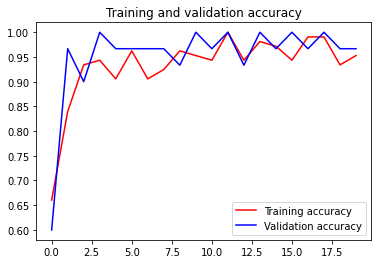

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

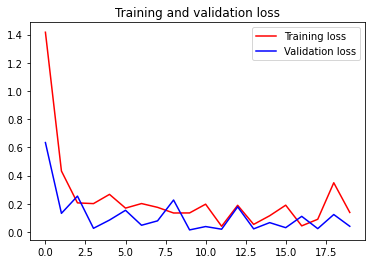

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [12]:
score = model.evaluate(test_generator, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.040454864501953125
Test accuracy: 0.9666666388511658


## 5. CAM

In [13]:
import cv2
from google.colab.patches import cv2_imshow

file_path='/content/gdrive/MyDrive/pose_test/test1.jpg'
image=cv2.imread(file_path)
#cv2_imshow(image)

In [14]:
image.shape

(1920, 1080, 3)

In [15]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-6].output, model.layers[-1].output))
cam_model.summary()
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0   

(512, 2)

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 160 x 160
        features (array) -- features of the image, shape (1, 20, 20, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    print("features_for_img:", features_for_img.shape)
    prediction = results[0]
    print("prediction:", prediction.shape)

    class_activation_weigths = gap_weights[:,label] 
    print("class_activation_weigths:", class_activation_weigths.shape)
    class_activation_features = sp.ndimage.zoom(features_for_img, (32, 32, 1), order=2)
    print("class_activation_features:", class_activation_features.shape)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (160,160))
 
    # visualize the results
    print(f'softmax output: {results}')
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [17]:
def normalize_and_resize(image):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (160, 160))
    image = tf.expand_dims(image, axis=0)
    return image


model.predict(normalize_and_resize(image))

1/1 [==============================] - 1s 794ms/step


array([[0.000, 1.000]], dtype=float32)

1/1 [==============================] - 0s 220ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.000 1.000]]


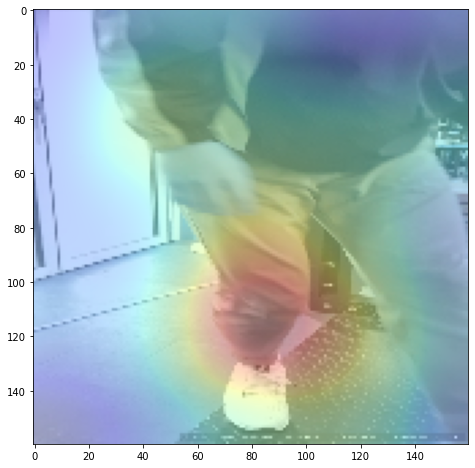

In [18]:
tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image))
show_cam(normalize_and_resize(image), features, results, lbl)

1/1 [==============================] - 0s 22ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.061 0.939]]


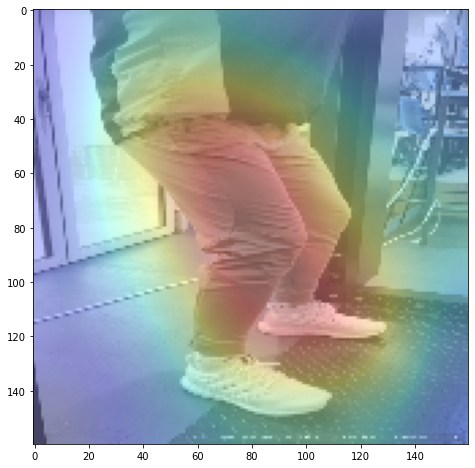

In [19]:
file_path2='/content/gdrive/MyDrive/pose_test/test2.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 19ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.379 0.621]]


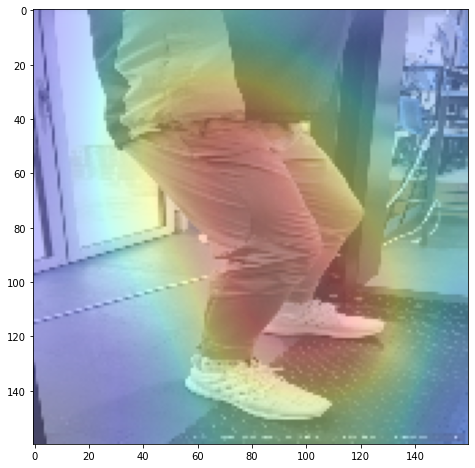

In [20]:
file_path2='/content/gdrive/MyDrive/pose_test/test3.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 23ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.184 0.816]]


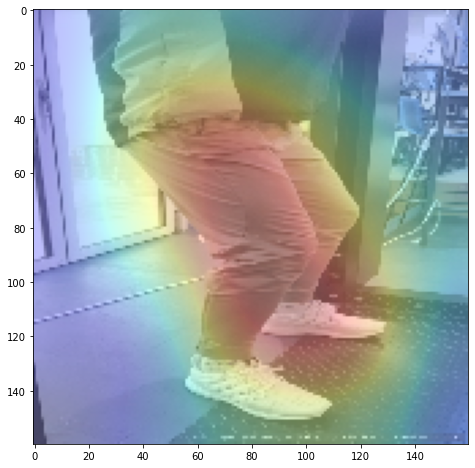

In [21]:
file_path2='/content/gdrive/MyDrive/pose_test/test4.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 28ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.275 0.725]]


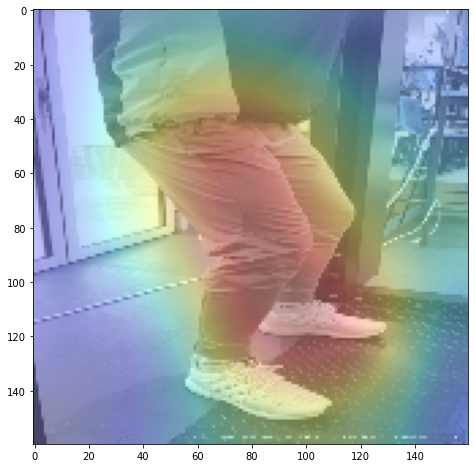

In [22]:
file_path2='/content/gdrive/MyDrive/pose_test/test5.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 24ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.956 0.044]]


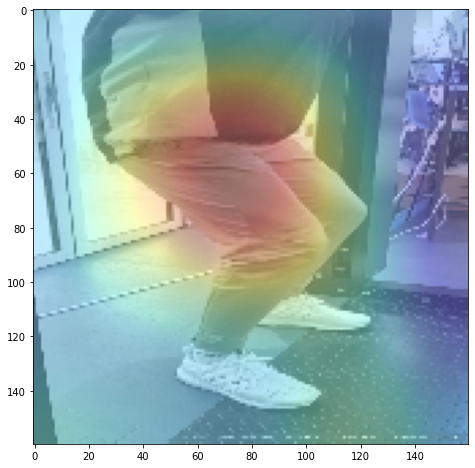

In [23]:
file_path2='/content/gdrive/MyDrive/pose_test/test6.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 19ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[1.000 0.000]]


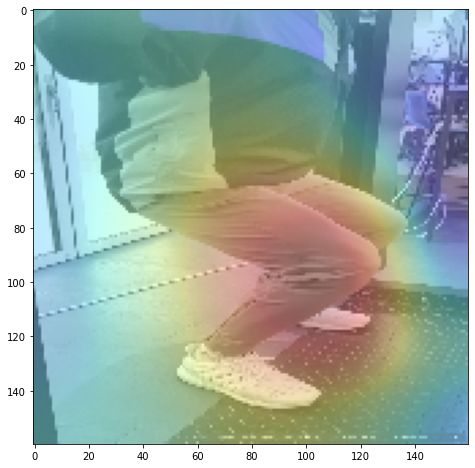

In [24]:
file_path2='/content/gdrive/MyDrive/pose_test/test7.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 24ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.966 0.034]]


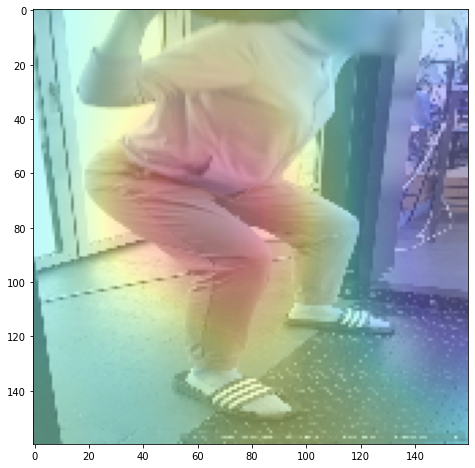

In [25]:
file_path2='/content/gdrive/MyDrive/pose_test/test8.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 21ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.000 1.000]]


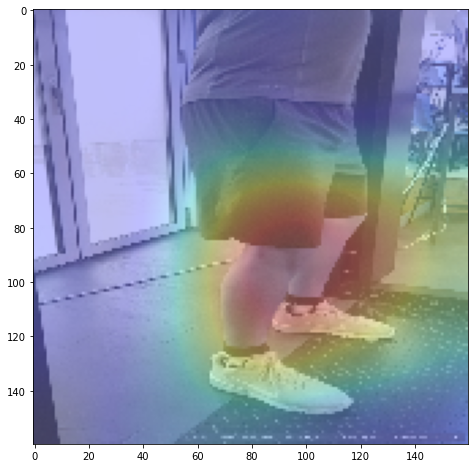

In [26]:
file_path2='/content/gdrive/MyDrive/pose_test/test9.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)

1/1 [==============================] - 0s 20ms/step
features_for_img: (5, 5, 512)
prediction: (2,)
class_activation_weigths: (512,)
class_activation_features: (160, 160, 512)
softmax output: [[0.000 1.000]]


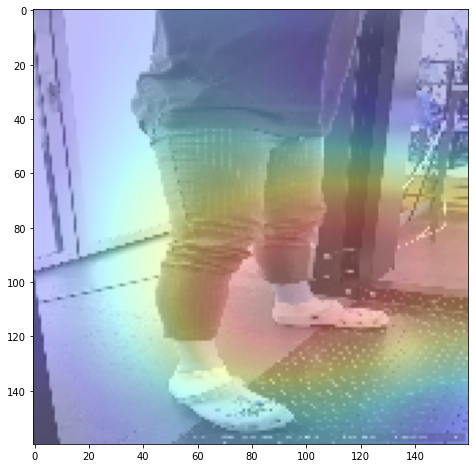

In [27]:
file_path2='/content/gdrive/MyDrive/pose_test/test10.jpg'
image2=cv2.imread(file_path2)
#cv2_imshow(image2)
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
show_cam(normalize_and_resize(image2), features, results, lbl)